# Data Structuring and Pruning

In [5]:
## python 2.7 setup
# !pip install pathlib

## we need a python2 version of pyupset
# !pip uninstall -y pyupset
# !pip install https://github.com/agitter/py-upset/archive/master.zip
# !pip install seaborn

from __future__ import division

In [6]:
# where are data files loaded
%env DATAPATH=/util/elastic/
PAPER_SOURCES=['brca.json','cgi.json', 'civic.json', 'jax.json', 'molecularmatch.json', 'oncokb.json', 'pmkb.json']

env: DATAPATH=/util/elastic/


In [7]:
# Load datasets

import json
import pathlib
import os

data_path = pathlib.Path(os.getenv('DATAPATH','/Users/awagner/Workspace/git/g2p-aggregator/data/local/0.8'))
harvested_sources = dict()
for path in [list(data_path.glob(file))[0] for file in PAPER_SOURCES]:
    source = path.parts[-1].split('.')[0]
    with path.open() as json_data:
        # harvested_sources[source] = json.load(json_data) <- this should work, but doesn't due to malformed json
        # what follows is a hack to reassemble into proper JSON object
        associations = list()
        for line in json_data:
            associations.append(json.loads(line))
        
        # resume intended function
        harvested_sources[source] = associations

In [8]:
# Standardize structure and merge files

all_associations = list()
for source in harvested_sources:
    for entry in harvested_sources[source]:
        entry['raw'] = entry.pop(source)
        all_associations.append(entry)
        
len(all_associations)

22617

In [9]:
from collections import Counter

def report_groups(associations):
    groups = Counter()
    for association in associations:
        groups[association['source']] += 1
    total = sum(groups.values())
    for group in sorted(groups):
        print("{}: {} ({:.1f}%)".format(group, groups[group], groups[group] / len(harvested_sources[group]) * 100))
    print("Total: {} ({:.1f}%)".format(total, total / len(all_associations) * 100))

In [10]:
report_groups(all_associations)

brca: 5717 (100.0%)
cgi: 1073 (100.0%)
civic: 3340 (100.0%)
jax: 5754 (100.0%)
molecularmatch: 2085 (100.0%)
oncokb: 4048 (100.0%)
pmkb: 600 (100.0%)
Total: 22617 (100.0%)


In [11]:
# Associations with more than 1 feature
multi_featured = [x for x in all_associations if len(x['features']) > 1]
len(multi_featured) / len(all_associations)

0.09262943803333776

In [12]:
report_groups(multi_featured)

cgi: 231 (21.5%)
civic: 1 (0.0%)
jax: 1797 (31.2%)
molecularmatch: 22 (1.1%)
oncokb: 44 (1.1%)
Total: 2095 (9.3%)


In [13]:
# Associations with feature name lists
listed_feature_names = [x for x in all_associations if isinstance(x['feature_names'], list)]
len(listed_feature_names) / len(all_associations)

0.0

In [14]:
report_groups(listed_feature_names)

Total: 0 (0.0%)


In [15]:
len([x for x in listed_feature_names if len(x['feature_names']) >1 ])

0

## Feature coordinate filtering

What follows is a detailed look at associations without start and end coordinates after normalization, and a set of regular expression filters to separate out these associations into chunks that can be annotated with gene- or exon-level coordinates, as appropriate.

In [16]:
# Associations with coordinate features
coord_featured = list()
no_coord_featured = list()
for association in all_associations:
    c = 0
    for feature in association['features']:
        if ('start' in feature) and ('end') in feature:
            coord_featured.append(association)
            break
        else:
            c+=1
    if c == len(association['features']):
        no_coord_featured.append(association)

In [17]:
report_groups(coord_featured)

brca: 5717 (100.0%)
cgi: 1069 (99.6%)
civic: 3340 (100.0%)
jax: 5744 (99.8%)
molecularmatch: 2068 (99.2%)
oncokb: 4043 (99.9%)
pmkb: 600 (100.0%)
Total: 22581 (99.8%)


In [18]:
report_groups(no_coord_featured)

cgi: 4 (0.4%)
jax: 10 (0.2%)
molecularmatch: 17 (0.8%)
oncokb: 5 (0.1%)
Total: 36 (0.2%)


In [19]:
# First association has feature, but no end coord

harvested_sources['cgi'][0]['features']

[{u'alt': u'T',
  u'biomarker_type': u'MUT',
  u'chromosome': u'9',
  u'description': u'ABL1 T315I',
  u'end': 133748283,
  u'geneSymbol': u'ABL1',
  u'links': [u'http://myvariant.info/v1/variant/chr9:g.133748283C>T?assembly=hg19',
   u'http://reg.genome.network/refseq/RS000057',
   u'http://reg.genome.network/refseq/RS000033',
   u'http://reg.genome.network/refseq/RS000009',
   u'http://reg.genome.network/refseq/RS002120',
   u'http://reg.genome.network/allele/CA122575',
   u'http://www.ncbi.nlm.nih.gov/snp/121913459',
   u'http://myvariant.info/v1/variant/chr9:g.130872896C>T?assembly=hg38',
   u'http://www.ncbi.nlm.nih.gov/clinvar/?term=27663[alleleid]',
   u'http://cancer.sanger.ac.uk/cosmic/mutation/overview?id=12560',
   u'http://www.ncbi.nlm.nih.gov/clinvar/variation/12624'],
  u'name': u'ABL1:T315I',
  u'provenance': [u'http://reg.genome.network/allele?hgvs=NC_000009.11%3Ag.133748283C%3ET'],
  u'provenance_rule': u'from_source',
  u'ref': u'C',
  u'referenceName': u'GRCh37',
  u

In [20]:
# Associations with partial coordinate features
partial_coord_featured = list()
no_partial_coord_featured = list()
for association in all_associations:
    c = 0
    for feature in association['features']:
        if ('start' in feature):
            partial_coord_featured.append(association)
            break
        else:
            c+=1
    if c == len(association['features']):
        no_partial_coord_featured.append(association)

In [21]:
report_groups(no_partial_coord_featured)

cgi: 4 (0.4%)
jax: 10 (0.2%)
molecularmatch: 17 (0.8%)
oncokb: 5 (0.1%)
Total: 36 (0.2%)


In [22]:
def get_feature_names(associations):
    return (list(map(lambda x: x['feature_names'], associations)))
feature_names = get_feature_names(no_partial_coord_featured)

In [23]:
no_partial_coord_featured_no_feature_names = [x for x in no_partial_coord_featured if x['feature_names'] is None]
no_partial_coord_featured_with_feature_names = [x for x in no_partial_coord_featured if x['feature_names'] is not None]

In [24]:
report_groups(no_partial_coord_featured_no_feature_names)

molecularmatch: 11 (0.5%)
Total: 11 (0.0%)


In [25]:
# All of these have exactly 1 gene name

len([x['genes'] for x in no_partial_coord_featured_no_feature_names if len(x['genes']) == 1])

11

In [26]:
report_groups(no_partial_coord_featured_with_feature_names)

cgi: 4 (0.4%)
jax: 10 (0.2%)
molecularmatch: 6 (0.3%)
oncokb: 5 (0.1%)
Total: 25 (0.1%)


In [27]:
import re

def test_curls(associations):
    # utility to generate curl commands
    names = []
    for a in associations:
        for f in a['features']:
            parts = re.split(' +|:',f['description'].strip())
            names.append(tuple(parts))
    names = list(set(names))
    feature_lookups = [t for t in names if len(t) > 1]
    if len(feature_lookups) > 0:
        print '# curl commands to find feature location'
        for t in feature_lookups:
            print "curl -s 'http://myvariant.info/v1/query?q={}%20{}'  | jq '.hits[0] | {{name: \"{} {}\", referenceName: \"GRCh37\", chromosome: .chrom, start: .hg19.start, end: .hg19.end, ref: .vcf.ref, alt: .vcf.alt }}'".format(t[0],t[1], t[0],t[1])

    gene_lookups = [t for t in names if len(t) == 1]
    if len(gene_lookups) > 0:
        print '# curl commands to find gene location'
        for t in gene_lookups:
            print "curl -s 'http://mygene.info/v3/query?q={}&fields=genomic_pos_hg19'  | jq .hits[0].genomic_pos_hg19".format(t[0])


def feature_filter(re_obj, associations):
    # report matches and return non-matches
    found = list(filter(lambda x: re_obj.search(x['feature_names']) is not None, associations))
    not_found = list(filter(lambda x: re_obj.search(x['feature_names']) is None, associations))
    report_groups(found)
    # comment following line to suppress curl test commands
    test_curls(found)
    return(not_found, found)



In [28]:
amp_re = re.compile(r'(amplification)|(loss)|(amp)', re.IGNORECASE)
(remainder, found)  = feature_filter(amp_re, no_partial_coord_featured_with_feature_names)

oncokb: 1 (0.0%)
Total: 1 (0.0%)
# curl commands to find feature location
curl -s 'http://myvariant.info/v1/query?q=WHSC1L1%20Amplification'  | jq '.hits[0] | {name: "WHSC1L1 Amplification", referenceName: "GRCh37", chromosome: .chrom, start: .hg19.start, end: .hg19.end, ref: .vcf.ref, alt: .vcf.alt }'


In [29]:
fusion_re = re.compile(r'(\w{2,}-\w{2,})|(fusion)', re.IGNORECASE)
(r2, found) = feature_filter(fusion_re, remainder)

oncokb: 3 (0.1%)
Total: 3 (0.0%)
# curl commands to find feature location
curl -s 'http://myvariant.info/v1/query?q=Other%20Biomarkers'  | jq '.hits[0] | {name: "Other Biomarkers", referenceName: "GRCh37", chromosome: .chrom, start: .hg19.start, end: .hg19.end, ref: .vcf.ref, alt: .vcf.alt }'


In [30]:
ppm_re = re.compile(r'\w+(:| )[a-z]\d+[a-z]?(fs\*?)?$', re.IGNORECASE)
(r3, found) = feature_filter(ppm_re, r2)

Total: 0 (0.0%)


In [31]:
indel_re = re.compile(r'\w+(:| )\w+(ins\w+)|(del($|ins\w+))|(dup$)')
(r4, found) = feature_filter(indel_re, r3)

jax: 4 (0.1%)
Total: 4 (0.0%)
# curl commands to find feature location
curl -s 'http://myvariant.info/v1/query?q=BRCA2%20del'  | jq '.hits[0] | {name: "BRCA2 del", referenceName: "GRCh37", chromosome: .chrom, start: .hg19.start, end: .hg19.end, ref: .vcf.ref, alt: .vcf.alt }'


In [32]:
bucket_re = re.compile(r'[A-Z0-9]+( (in)?act)?( oncogenic)? mut((ant)|(ation))?$')
(r5,found) = feature_filter(bucket_re, r4)

cgi: 1 (0.1%)
Total: 1 (0.0%)
# curl commands to find feature location
curl -s 'http://myvariant.info/v1/query?q=MLL2%20oncogenic'  | jq '.hits[0] | {name: "MLL2 oncogenic", referenceName: "GRCh37", chromosome: .chrom, start: .hg19.start, end: .hg19.end, ref: .vcf.ref, alt: .vcf.alt }'


In [33]:
exon_re = re.compile(r'exon', re.IGNORECASE)
(r6,found) = feature_filter(exon_re, r5)

Total: 0 (0.0%)


In [34]:
expression_re = re.compile(r'(exp)|(^\w+ (pos(itive)?)|(neg(ative)?)|(biallelic inactivation)$)|(truncating)|(deletion)', re.IGNORECASE)
(r7, found) = feature_filter(expression_re, r6)

oncokb: 1 (0.0%)
Total: 1 (0.0%)
# curl commands to find feature location
curl -s 'http://myvariant.info/v1/query?q=FAM58A%20Truncating'  | jq '.hits[0] | {name: "FAM58A Truncating", referenceName: "GRCh37", chromosome: .chrom, start: .hg19.start, end: .hg19.end, ref: .vcf.ref, alt: .vcf.alt }'


In [35]:
report_groups(r7)

cgi: 3 (0.3%)
jax: 6 (0.1%)
molecularmatch: 6 (0.3%)
Total: 15 (0.1%)


In [36]:
get_feature_names([x for x in r7 if x['source'] == 'cgi'])

[u'MAP2K1 (Q56P,P124S,P124L;C121S)',
 u'JAK1 (S646F;R683)',
 u'MET (Y1230C;Y1235D)']

# Knowledgebase Comparison

## Genes

In [37]:
from collections import defaultdict

def genes_by_source(associations):
    source_genes = defaultdict(set)
    for association in associations:
        source_genes[association['source']].update(association['genes'])
    return source_genes

In [38]:
s = genes_by_source(all_associations)

In [39]:
import pyupset as pyu
import pandas as pd
%matplotlib inline

def plot_overlap(set_dict):
    d = {g: pd.DataFrame(list(set_dict[g])) for g in set_dict}
    pyu.plot(d, inters_size_bounds=(3, 400000))

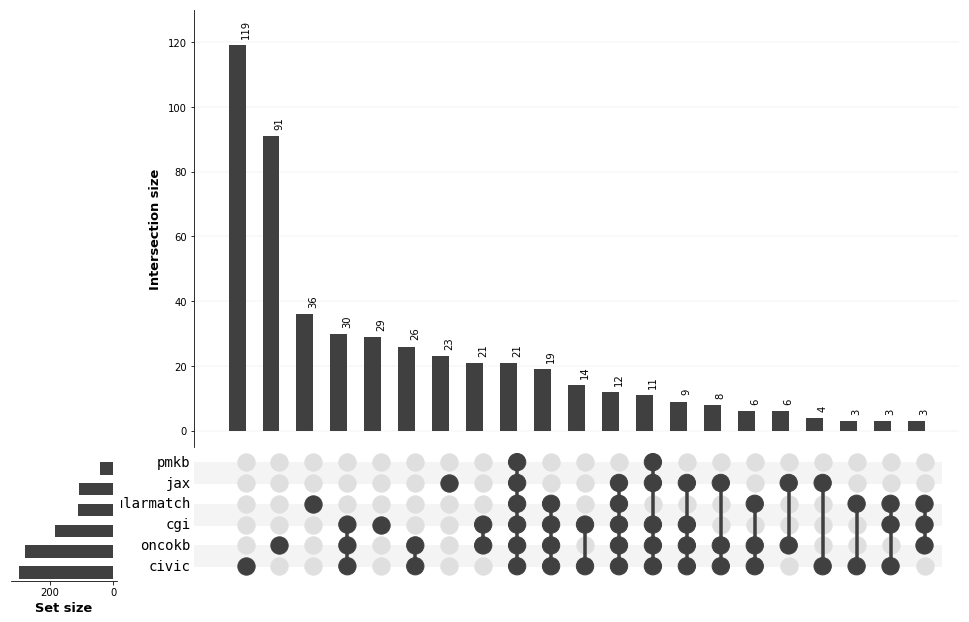

In [40]:
# omitting BRCA (only 2 genes)
s = {k: v for k, v in s.items() if k != 'brca'}
plot_overlap(s)

In [41]:
# Genes observed in all knowledgebases


In [42]:
# 
# features provenance
provenance = {'unknown_provenance':0}
unknown_provenance = []
for association in all_associations:
    c = 0
    for feature in association['features']:
        if 'provenance_rule' in feature:
            if feature['provenance_rule'] not in provenance:
                provenance[feature['provenance_rule']] = 0
            provenance[feature['provenance_rule']] += 1
        else:
            provenance['unknown_provenance'] += 1            
            unknown_provenance.append([association['source'], feature])

provenance


{u'default_feature': 6926,
 u'from_source': 18093,
 u'gene_only': 379,
 u'is_amplification': 324,
 u'is_deletion': 429,
 u'is_fusion_acceptor': 1002,
 u'is_fusion_donor': 1011,
 u'is_inact_mut': 156,
 u'is_loss': 257,
 u'is_mutation': 517,
 'unknown_provenance': 64}

In [43]:
for unknown in unknown_provenance:
    print unknown[0], unknown[1]['description']

cgi FLT3-ITD
cgi FLT3-ITD
cgi FLT3-ITD
cgi FLT3-ITD
cgi MAP2K1 (Q56P,P124S,P124L;C121S)
cgi FLT3-ITD
cgi JAK1 (S646F;R683)
cgi MLL2 oncogenic mutation
cgi MET (Y1230C;Y1235D)
jax BRAF V600E/K 
jax BRAF V600E/K 
jax BRAF V600E/K 
jax BRAF V600E/K 
jax BRAF V600E/K 
jax BRAF V600E/K 
jax BRAF V600E/K 
jax BRAF V600E/K 
jax BRAF V600E/K 
jax BRCA2  del
jax BRAF V600E/K 
jax BRAF V600E/K 
jax BRAF V600E/K 
jax BRAF V600E/K 
jax BRAF V600E/K 
jax BRCA2  del
jax BRCA2  del
jax BRCA2  del
civic HLA-C COPY-NEUTRAL LOSS OF HETEROZYGOSITY
molecularmatch MET MET c.2888-52_2927delGGGGCCCATGATAGCCGTCTTTAACAAGCTCTTTCTTTCTCTCTGTTTTAAGATCTGGGCAGTGAATTAGTTCGCTACGATGCAAGAGTACAinsCC
molecularmatch PGR ER/PR positive
molecularmatch PGR ER/PR positive
molecularmatch MET MET c.2888-6_2888-2delTTTAAinsG
molecularmatch MET MET c.2888-15_2915delTCTCTCTGTTTTAAGATCTGGGCAGTGAATTAGTTCGCTACGAinsT
molecularmatch PGR ER/PR positive
molecularmatch PGR ER/PR positive
molecularmatch PGR ER/PR positive
molecularmatch MET